# What is driving the errors in Zestimates?

---

By: Alejandro Garcia
<br>
Date: April 8, 2022

---

## Project Goals

The goal of this project is to identify drivers of logerror in the Zillow property value estimates and produce a model for predicting the logerror using these drivers.

---

## Project Description

Zillow is interested in identifying what attributes are driving the logerror in their Zestimates. This is important to help produce better prediction models so that Zillow can remain competitive in the housing market. With this in mind we are interested in producing a model for predicting logerror and identifying actionable recommendations that could help reduce the overall average logerror. Additionally, we are interested in single family/single unit properties with transactions in 2017.

---

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
# Here we are importing everything needed to execute the code blocks in this notebook.
from acquire import AcquireZillow
from prepare import prepare_and_split
from explore import *
from model import *
from preprocessing import scale_data, remove_outliers

# We would like to ignore any warnings that may be provided by our libraries.
import warnings
warnings.filterwarnings("ignore")

---

## Data Acquisition and Preparation

The data is acquired from data.codeup.com using a SQL query. Acquiring the data takes some time so it is cached in a local "zillow.csv" file for quicker access in the future. The "zillow.csv" file is not stored in the Github repository.

We are interested in properties that had a transaction in 2017. For any properties with more than one transaction we only want the most recent transaction. All this is done in SQL. We also want all attributes for each property except for any foreign key columns. ~77,000 observations are retrieved.

**Missing Values:**
<br>
Initial analysis of the data reveals that there is a large amount of missing values. The goal was to keep the preparation simple due to time constraints, so we simply drop all the nulls. However, in order to prevent a large loss of data we do this in two steps:
    - Remove any columns that are missing more than 20% of values.
    - Remove any rows with a missing value.
This results in a loss of ~13,000 observations which was deemed acceptable since we still had more than 80% of the data.

**Single Family/Single Unit Properties:**
<br>
We are also only interested in single family/single unit properties. To do this we remove any properties where the property type description is not one of the following: Single Family Residential, Condominium, Cluster Home, Mobile Home, Manufactured Home, and Townhouse.

In [2]:
# Here we will acquire, prepare, and split the zillow property data and store the results in our train, validate, 
# and test dataframes. Details can be found in the prepare.py file.
train, validate, test = prepare_and_split(AcquireZillow().get_data())

---

## Exploratory Analysis

With the data prepared and split we can begin exploring the data to identify which features will be most useful for predicting logerror.

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

### Is there a relationship between tax assessed value and logerror?

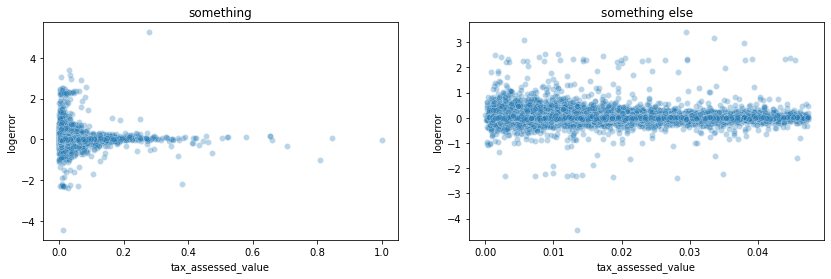

In [16]:
# Here we will plot tax assessed value vs. logerror.
# On the left is the chart with outliers,
# on the right is the chart without outliers.
plot_tax_value_and_logerror(train)

$H_0$: The mean logerror for properties with tax assessed value less than 250,000 is equal to the mean logerror for properties with tax assessed value greater than 250,000.
<br>
$H_a$: The mean logerror for properties with tax assessed value less than 250,000 is not equal to the mean logerror for properties with tax assessed value greater than 250,000.

In [24]:
# Here we will perform a two sample t-test between properties with tax assessed value less than $250,000
# and properties with tax assessed value greater than $250,000 comparing the mean logerror.
run_stats_test_for_tax_value(train)

Fail to reject H0


In [23]:
%run explore.py

---

## Modeling

Before building and training machine learning models the data needs to be scaled so that all features are weighted equally. Additionally, we should remove outliers from the training set so that they don't influence the model's behavior.

In [3]:
# Here we will scale all of our data except for the target variable logerror.
# The data is scaled using a MinMaxScaler.
train, validate, test = scale_data(
    train,
    validate,
    test,
    train.drop(columns = 'logerror').columns
)

# Now we will remove outliers from the train dataset. We will store this data 
# with outliers removed in a separate variable since we still want to use the 
# original data with outliers for evaluating the models. The only columns with 
# significant outliers are square_feet and tax_assessed_value.
train_no_outliers = remove_outliers(train, 1.5, ['square_feet', 'tax_assessed_value'])

Now we can begin creating machine learning models. We will try creating a few models without the cluster feature and a few with it to see if it makes a difference. The performance of each model will be evaluated using the root mean squared error which will give us the average distance between the predicted values and the actual values. With this evaluation metric we will know how far off the predictions are on average.

First though, we must establish a baseline model with which to compare our models so that we may determine if our models perform better than a naive model.

In [4]:
# Here we establish a baseline model which will either the mean or median of the target, whichever 
# provides the lower RMSE score.
baseline = establish_baseline(train['logerror'])

Now with the baseline model established we can create our models.

In [5]:
# Here we will create eight different models and evaluate all of them using RMSE.
# For details refer to the model.py or model.ipynb files.
# The features used are:
#
models = create_models(train_no_outliers)
evaluate_models(baseline, models, train, validate, 'logerror')

,RMSE_train,RMSE_validate
baseline,0.165812,NaN
linear_regression_no_clusters,0.165788,0.171489
tweedie_regressor_no_clusters,0.165793,0.171265
polynomial_regression_no_clusters,0.354940,0.446750
polynomial_regression_interactions_only_no_clusters,0.192407,0.198940
linear_regression_with_clusters,0.165807,0.171535
tweedie_regressor_with_clusters,0.165793,0.171265
polynomial_regression_with_clusters,0.380500,0.477052
polynomial_regression_interactions_only_with_clusters,0.195537,0.201117


It appears the linear regression model without the cluster feature has the best performance and only slightly better than the baseline. Let's now make predictions on test.

In [11]:
evaluate_on_test(models[1], test, 'logerror')

RMSE_test: 0.164388400008141


The performance on test is consistent with with train and validate.

---

## Key Takeaways and Recommendations



---

## Next Steps

